**HousingPriceKaggle**: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=sample_submission.csv

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from pandas import DataFrame as df
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [170]:
data=pd.read_csv('A:/Work/5/Kaggle/Housingprice/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('A:/Work/5/Kaggle/Housingprice/house-prices-advanced-regression-techniques/test.csv')

In [171]:
#data.hist(figsize=[20,18])
#Only use data with Normal SaleConditions
print ('The shape of the original data is '+str(data.shape))
data=data[data['SaleCondition']=='Normal']
print ('The shape of the data after the SaleCondition cut is '+str(data.shape))
#Only use numerical columns, also drop Id
pretrain=data.select_dtypes(exclude='object').drop('Id',axis=1)




The shape of the original data is (1460, 81)
The shape of the data after the SaleCondition cut is (1198, 81)


Text(0, 0.5, 'Features')

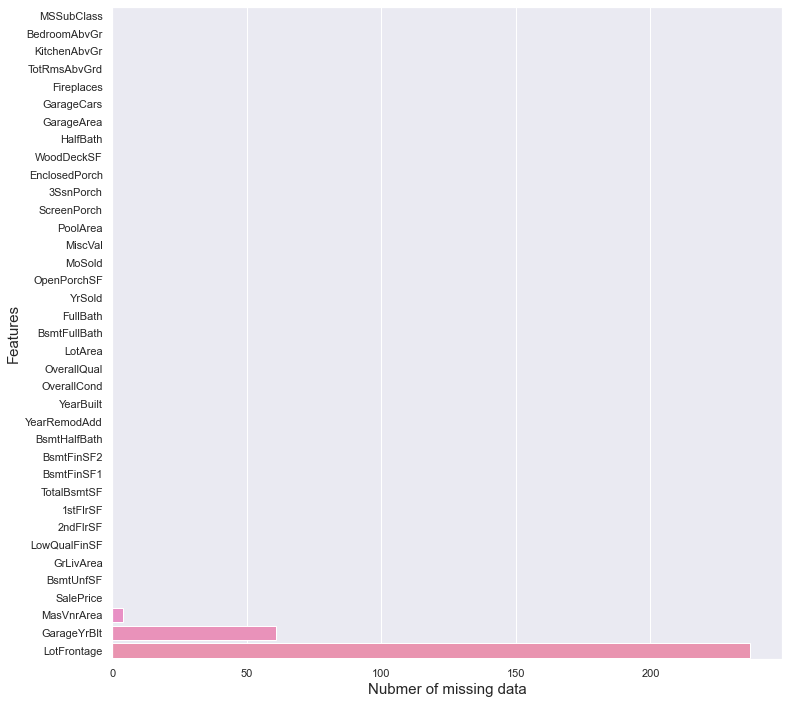

In [172]:
#See how many data are missing
Nulls=pretrain.isnull().sum().sort_values()
#plt.figure(figsize=(10,9))
#sns.set(font_scale=2.5)
#sns.set()
sns.set(rc={'figure.figsize':(12,12)})
#new names for plotting
#names=list(train.columns)
sns.barplot(x=Nulls,y=Nulls.index[:])
plt.xlabel('Nubmer of missing data',fontsize=15)
plt.ylabel('Features',fontsize=15)


In [173]:
pretrain['LotFrontage']=pretrain['LotFrontage'].fillna(pretrain['LotFrontage'].mean)
pretrain['GarageYrBlt']=pretrain['GarageYrBlt'].fillna(0)
pretrain['MasVnrArea']=pretrain['MasVnrArea'].fillna(0)
print ('Added missing values based on the nature of the labels: NaN in GarageYrBlt and MasVnrArea indicates no garage or Masonry so replace them with 0')
print ('check the max number of NaNs after adding missing values')
print (np.amax(pretrain.isnull().sum()))

Added missing values based on the nature of the labels: NaN in GarageYrBlt and MasVnrArea indicates no garage or Masonry so replace them with 0
check the max number of NaNs after adding missing values
0


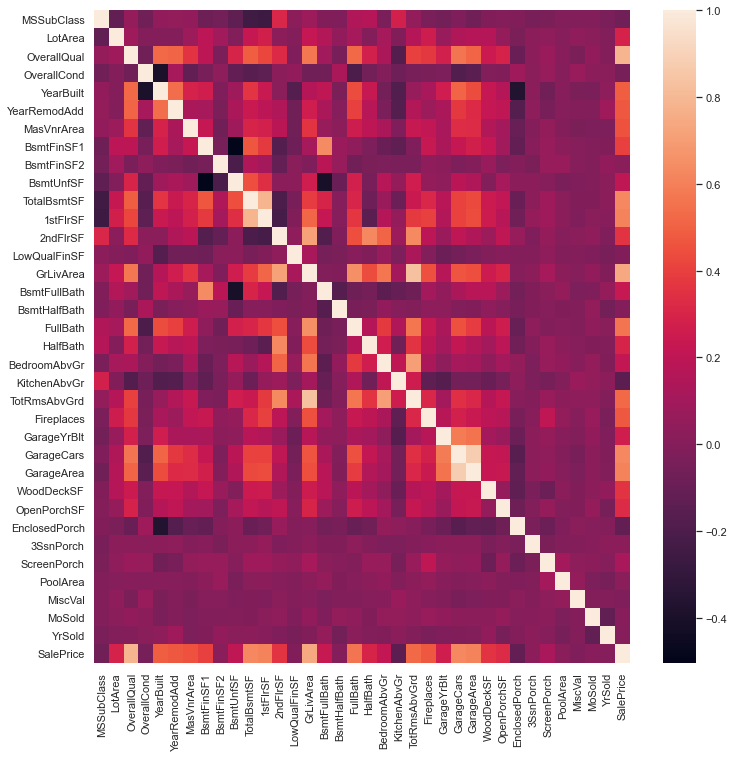

In [174]:
#Use corr to choose training features
mycorr=pretrain.corr()
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(mycorr,annot=False)

Text(0, 0.5, 'Features')

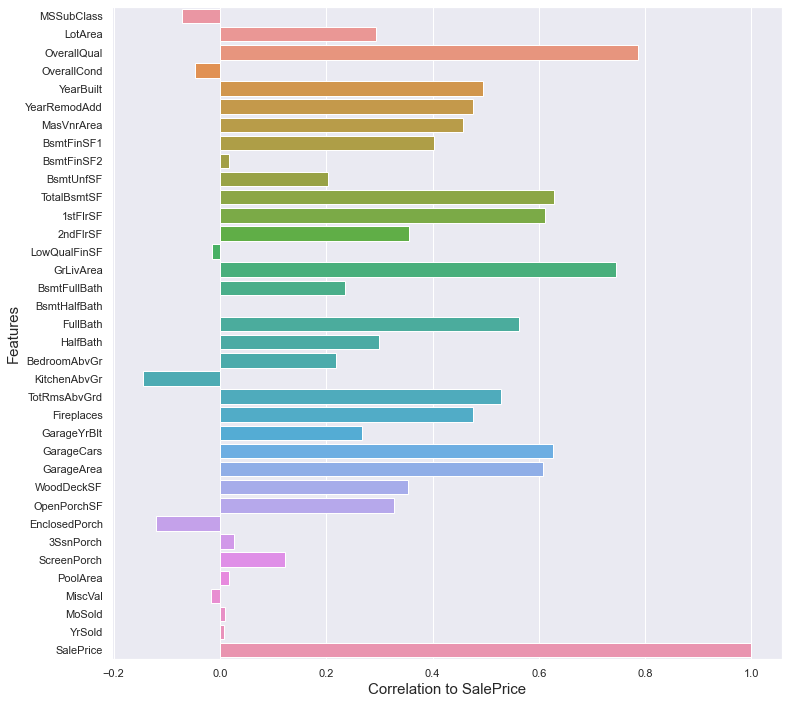

In [175]:
mycorr['SalePrice']
sns.set(rc={'figure.figsize':(12,12)})
sns.barplot(x=mycorr['SalePrice'],y=mycorr['SalePrice'].index[:])
plt.xlabel('Correlation to SalePrice',fontsize=15)
plt.ylabel('Features',fontsize=15)

In [176]:
#Choose training features
feature_names=list(mycorr[mycorr['SalePrice'] > 0.2].index[:])
feature_names.remove('SalePrice')
print (feature_names)

['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']


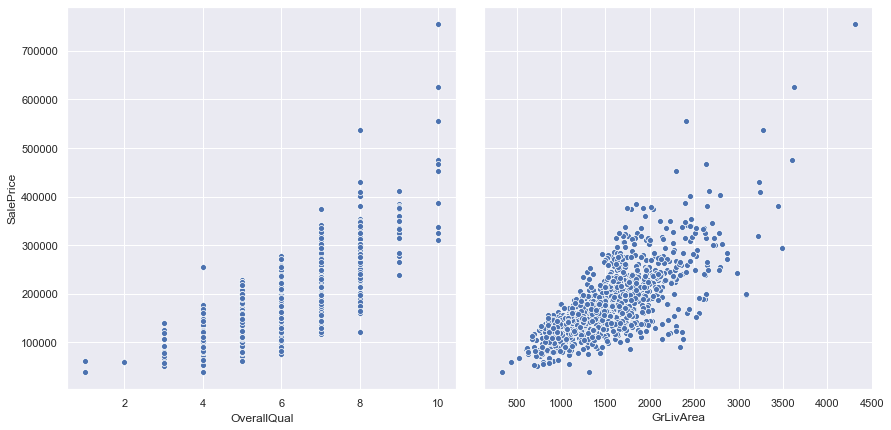

In [177]:
#Check for possible outliers
fig, ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
plt.tight_layout()
#sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x=pretrain['OverallQual'],y=pretrain['SalePrice'],ax=ax[0])
sns.scatterplot(x=pretrain['GrLivArea'],y=pretrain['SalePrice'],ax=ax[1])

Text(0, 0.5, 'Counts')

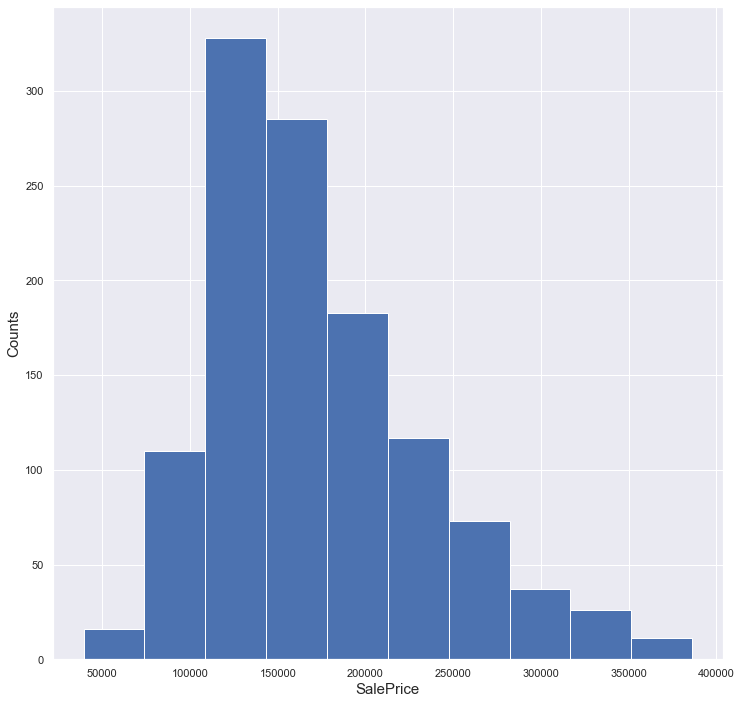

In [178]:
#Add a SalePrice cut (SalePrice <= 400000) to remove outliers
pretrain2=pretrain[pretrain['SalePrice']<= 400000]

#Finalize training data
train=pretrain2[feature_names]
Price=pretrain2['SalePrice']
#Visulize the Price
Price.hist(figsize=(12,12))
plt.xlabel("SalePrice", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Text(0, 0.5, 'Counts')

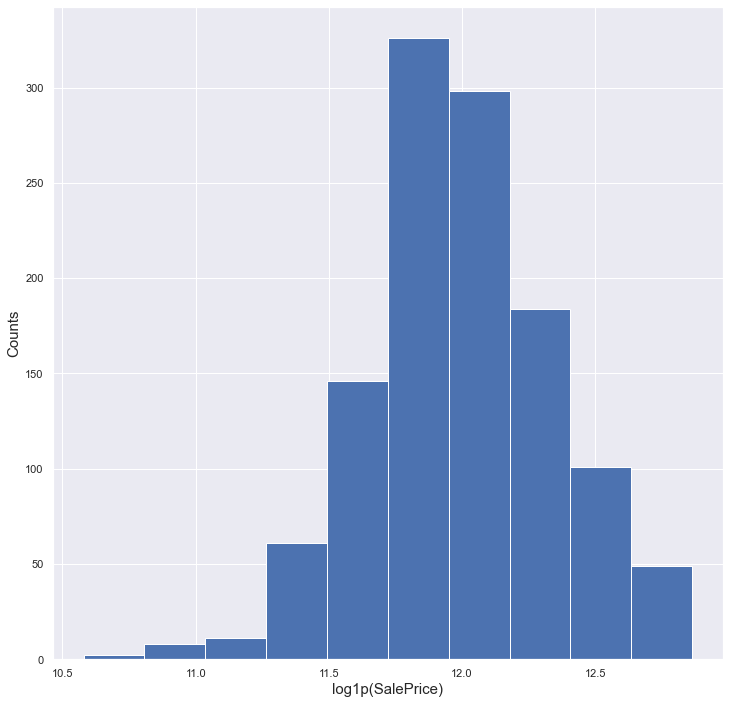

In [179]:
# It's clear that the Price does not follow a normal distribution well
#Do a np.log1p()
Price2=np.log1p(Price)
Price2.hist(figsize=(12,12))
plt.xlabel("log1p(SalePrice)", fontsize=15)
plt.ylabel("Counts", fontsize=15)

In [222]:
import warnings
warnings.filterwarnings("ignore")
x_train, x_val, y_train, y_val = train_test_split(train, Price2, test_size=0.3, random_state=0)

RFR = RandomForestRegressor(max_depth=15)
GBR = GradientBoostingRegressor()


RFR.fit(x_train,y_train)
GBR.fit(x_train,y_train)

scores_RFR=(np.sqrt(-(cross_val_score(RFR, x_val, list(y_val), cv=10,scoring='neg_mean_squared_error'))))
scores_GBR=(np.sqrt(-(cross_val_score(GBR, x_val, list(y_val), cv=10,scoring='neg_mean_squared_error'))))

y_pred_RFR=RFR.predict(x_val)
y_pred_GBR=GBR.predict(x_val)



print ('The 10-fold CV RMSE of Random Forest Regressor is '+str(scores_RFR.mean())+'+/-'+str(scores_RFR.std()))

print ('The 10-fold CV RMSE of Random Forest Regressor is '+str(scores_GBR.mean())+'+/-'+str(scores_GBR.std()))


The 10-fold CV RMSE of Random Forest Regressor is 0.14372093969653055+/-0.02747044584639065
The 10-fold CV RMSE of Random Forest Regressor is 0.12675125759355296+/-0.025014636086962683


In [206]:
#Prep for test set prediction
test2=test[feature_names]
print (test2.isnull().sum().sort_values()[-10:])
#Filling missing values with 0
To_test=test2.fillna(0)

mypred=np.expm1(GBR.predict(To_test))
#print (mypred[0])
result=df({"Id":test['Id'],"SalePrice":mypred})
#Output my predictions
result.to_csv('A:/Work/5/Kaggle/Housingprice/house-prices-advanced-regression-techniques/PeiboAn_HousePrice_test_result_GB2.csv',index=False)

1stFlrSF          0
OpenPorchSF       0
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF1        1
GarageCars        1
GarageArea        1
BsmtFullBath      2
MasVnrArea      262
GarageYrBlt     262
dtype: int64


Text(79.125, 0.5, 'Features')

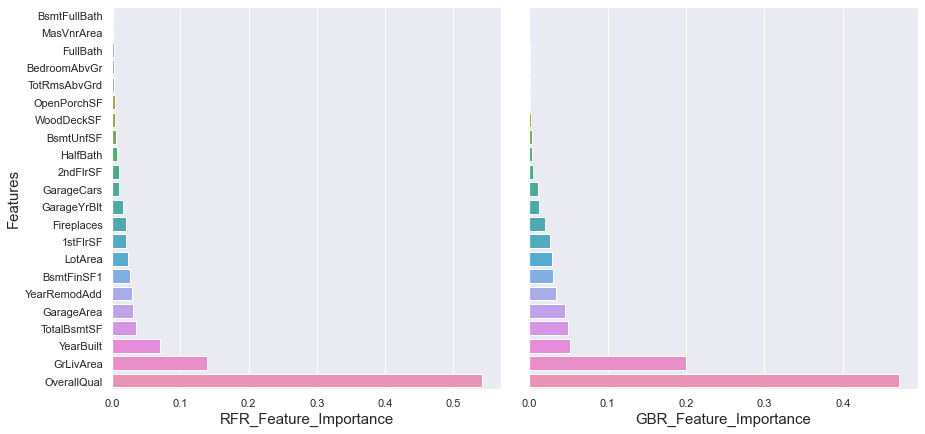

In [220]:
#check feature importances of the two trained models
myfeature_GBR=GBR.feature_importances_
myfeature_RFR=RFR.feature_importances_
fcheck_GBR=pd.Series(myfeature_GBR, index=list(train.columns)).sort_values(ascending=True)
fcheck_RFR=pd.Series(myfeature_RFR, index=list(train.columns)).sort_values(ascending=True)



fig, ax = plt.subplots(1,2,figsize=(12,6),sharey=True)
plt.tight_layout()
#new names for plotting
names=list(train.columns)
sns.barplot(x=fcheck_RFR,y=fcheck_RFR.index[:],ax=ax[0])
sns.barplot(x=fcheck_GBR,y=fcheck_GBR.index[:],ax=ax[1])
ax[0].set_xlabel('RFR_Feature_Importance',fontsize=15)
ax[1].set_xlabel('GBR_Feature_Importance',fontsize=15)
ax[0].set_ylabel('Features',fontsize=15)


In [221]:
import pickle
# save the Models
with open('HouseP3(GB2).pkl', 'wb') as mytree:
    pickle.dump(GBR, mytree)    
with open('HouseP3(RF2).pkl', 'wb') as mytree2:
    pickle.dump(RFR, mytree2)  
# load it again if needed
'''
with open('HouseP3(GB1).pkl', 'rb') as mytree:
    DTC_loaded = pickle.load(mytree)
'''

"\nwith open('HouseP3(GB1).pkl', 'rb') as mytree:\n    DTC_loaded = pickle.load(mytree)\n"